In [15]:
import numpy as np
import scipy as sp
import pandas as pd
import sklearn

# from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
#from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score,roc_curve

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

import seaborn as sns

In [16]:
data_set = pd.read_csv("data/trn.csv", sep=',', header=0, low_memory=False)

In [17]:
from scipy import stats

def get_metrics(y, pred, probas):
    accuracy = accuracy_score(y.values, pred)
    recall = recall_score(y.values, pred)
    precision = precision_score(y.values, pred)
    f1 = f1_score(y.values, pred)
    aupr = average_precision_score(y.values, pred)
    fpr, tpr, thresholds = roc_curve(y.values, probas, pos_label=1)
    ks = stats.ks_2samp(y.iloc[:,0].values, probas)
    return (accuracy, recall, precision, f1, aupr, fpr, tpr, thresholds, ks)

In [18]:
# encontra as variavies categoricas
for col in data_set.columns:
    if ((data_set[col].quantile() == 1.0) | (data_set[col].quantile() == 0.0)):
        data_set[col] = data_set[col].astype('category')

In [19]:
from sklearn.cross_validation import train_test_split

In [20]:
X = data_set.loc[:, data_set.columns !='y']
y = data_set.iloc[:, data_set.columns == 'y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/4, random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/3, random_state=42, stratify=y_train)

In [21]:
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots()

ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

In [22]:
from sklearn.ensemble import GradientBoostingClassifier as gb

In [23]:
gb_gs = gb(n_estimators=100)

In [24]:
gb_grid_params = {'learning_rate': [0.1,0.05,0.02,0.01],
                 'max_depth': [4,6,8],
                  #'min_sample_leaf': [20,50,100,150],
                 }

In [25]:
gb_clf = gb(n_estimators=200,learning_rate= 0.05, max_depth = 6)
gb_clf.fit(X_train.values, y_train.values.ravel())

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [26]:
predicted = gb_clf.predict(X_test.values)
accuracy = accuracy_score(y_test.values, predicted)
print("Mean accuracy score: {:.3}".format(accuracy))

Mean accuracy score: 0.655


,0,1
0,34.614983,15.385763
1,19.121836,30.877418


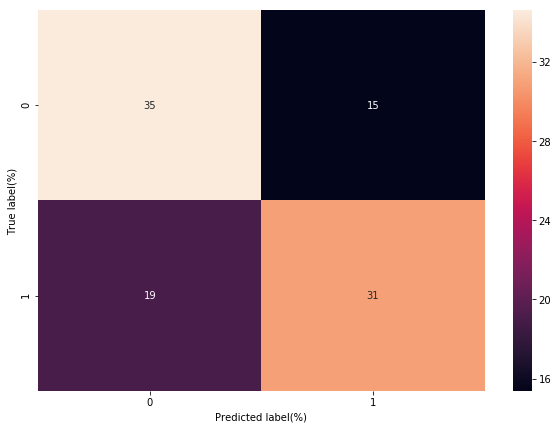

In [27]:
%matplotlib inline
cm = pd.DataFrame(confusion_matrix(y_test, predicted))
tot = cm.sum().sum()
cm = cm.applymap(lambda x: x*100/tot)
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(cm, annot=True)
plt.ylabel('True label(%)')
plt.xlabel('Predicted label(%)')
cm

In [28]:
y_pred_clf = gb_clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test.values, y_pred_clf, pos_label=1)

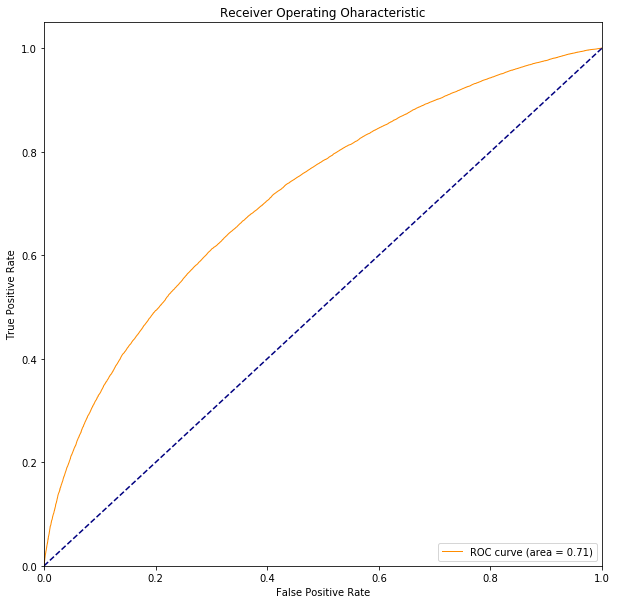

In [29]:
%matplotlib inline
from sklearn.metrics import auc

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
#plt.plot(tpr, fpr, color='darkblue', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Oharacteristic')
plt.legend(loc="lower right")
plt.show()

In [31]:
accuracy, recall, precision, f1, aupr, fpr, tpr, thresholds, ks = get_metrics(y_test, predicted, y_pred_clf)
print("Accuracy score: {:.3}".format(accuracy))
print("Recall score: {:.3}".format(recall))
print("Precision score: {:.3}".format(precision))
print("f1 score: {:.3}".format(f1))
print("Mean precison score: {:.3}".format(aupr))
#print("KS: {:.3}".format(ks[0]))

Accuracy score: 0.655
Recall score: 0.618
Precision score: 0.667
f1 score: 0.642
Mean precison score: 0.603


In [32]:
y_train_pred = gb_clf.predict(X_train.as_matrix()).ravel()
y_test_pred = gb_clf.predict(X_test.as_matrix()).ravel()

C:\Users\eduar\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
C:\Users\eduar\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [33]:
y_test_pred_prob = gb_clf.predict_proba(X_test.as_matrix())[:, 1]

C:\Users\eduar\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [34]:
import math
from scipy import stats

position = 0
class_0 = 0
class_1 = 0
counting_class_0 = [0] * 101
counting_class_1 = [0] * 101
grouped_counting_class_0 = [0] * 101
grouped_counting_class_1 = [0] * 101
percentage_counting_class_0 = [0.0] * 101
percentage_counting_class_1 = [0.0] * 101

for x in y_test['y']:
    score = math.floor(y_test_pred_prob[position]*100)
    if x == 0:
        class_0 = class_0 + 1
        counting_class_0[score] = counting_class_0[score] + 1
    else:
        class_1 = class_1 + 1
        counting_class_1[score]= counting_class_1[score] + 1
    position = position + 1

print(class_0, class_1)

last_value_class_0 = 0
last_value_class_1 = 0

for x in range(0, 101):
    last_value_class_0 += counting_class_0[x]
    grouped_counting_class_0[x] = last_value_class_0
    percentage_counting_class_0[x] = last_value_class_0/class_0
    
    last_value_class_1 += counting_class_1[x]
    grouped_counting_class_1[x] = last_value_class_1
    percentage_counting_class_1[x] = last_value_class_1/class_1

#stats.ks_2samp(percentage_counting_class_0, percentage_counting_class_1)
stats.ks_2samp(grouped_counting_class_0, grouped_counting_class_1)

33525 33524


Ks_2sampResult(statistic=0.17821782178217827, pvalue=0.07148265768062076)

In [31]:
gb_clf2 = gb(n_estimators=400, learning_rate=0.05)
gb_clf2.fit(X_train.values, y_train.values.ravel())

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=400,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [32]:
predicted2 = gb_clf2.predict(X_test.values)
accuracy2 = accuracy_score(y_test.values, predicted2)
print("Mean accuracy score: {:.3}".format(accuracy2))

Mean accuracy score: 0.653


,0,1
0,23253,10272
1,12995,20529


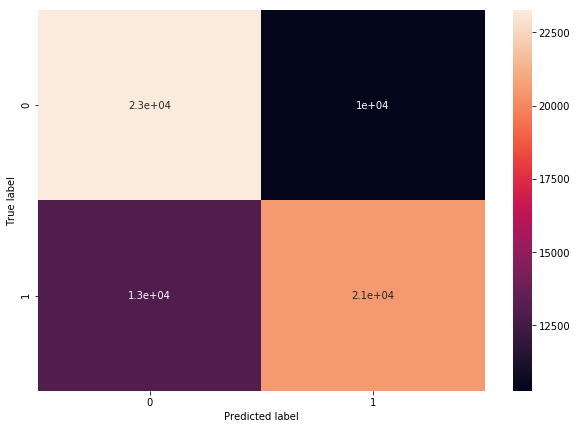

In [34]:
%matplotlib inline
cm2 = pd.DataFrame(confusion_matrix(y_test, predicted2))
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(cm2, annot=True)
plt.ylabel('True label')
plt.xlabel('Predicted label')
cm2

In [35]:
y_pred_clf = gb_clf2.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test.values, y_pred_clf, pos_label=1)

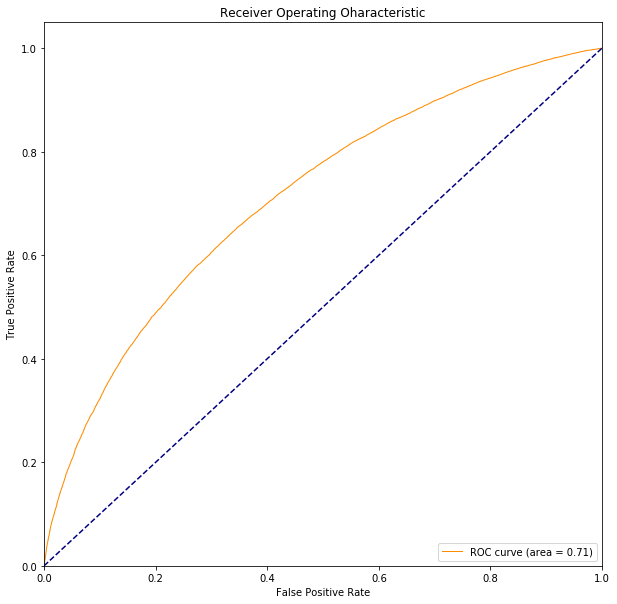

In [36]:
%matplotlib inline
from sklearn.metrics import auc

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
#plt.plot(tpr, fpr, color='darkblue', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Oharacteristic')
plt.legend(loc="lower right")
plt.show()

In [29]:
#ks = stats.ks_2samp(y_test.iloc[:,0].values, predicted)

ks = stats.ks_2samp(y_test.iloc[:,0].values, y_pred_clf)

ks

Ks_2sampResult(statistic=0.5000074572327701, pvalue=0.0)

In [28]:
accuracy, recall, precision, f1, aupr, fpr, tpr, thresholds, ks = get_metrics(y_test, predicted2, y_pred_clf)
print("Accuracy score: {:.3}".format(accuracy))
print("Recall score: {:.3}".format(recall))
print("Precision score: {:.3}".format(precision))
print("f1 score: {:.3}".format(f1))
print("Mean precison score: {:.3}".format(aupr))
print("KS: {:.3}".format(ks[0]))


Accuracy score: 0.653
Recall score: 0.612
Precision score: 0.667
f1 score: 0.638
Mean precison score: 0.602
KS: 0.5


In [31]:
from sklearn import grid_search

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [ ]:
clf = grid_search.GridSearchCV(gb_gs,
                               gb_grid_params,
                               cv=2,
                               scoring='roc_auc',
                               verbose = 3, 
                               n_jobs=10)
clf.fit(X_train.values, y_train.values.ravel())

Fitting 2 folds for each of 12 candidates, totalling 24 fits
